In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# defining path
path =r'C:\Users\dog\Desktop\Boat sales'

In [3]:
# importing cleaned data
df = pd.read_csv(os.path.join(path, '02 Prepared Data', '27.01.df_boats_cleaned6.2..csv'))

In [4]:
# changing the year_built column to datetime format so that we can use it later on
df['year_built'] = pd.to_datetime(df['year_built'], format='%Y')

In [5]:
# checking if that worked out
df.dtypes

Unnamed: 0                    int64
boat_type                    object
manufacturer                 object
type                         object
year_built           datetime64[ns]
length                      float64
width                       float64
material                     object
views_last_7_days             int64
currency                     object
value                         int64
value_in_eur                  int64
country                      object
type_ad                      object
type_ad_DROP                 object
boat_type_clean              object
Boat_Type_DROP               object
boat_condition               object
price_range                  object
dtype: object

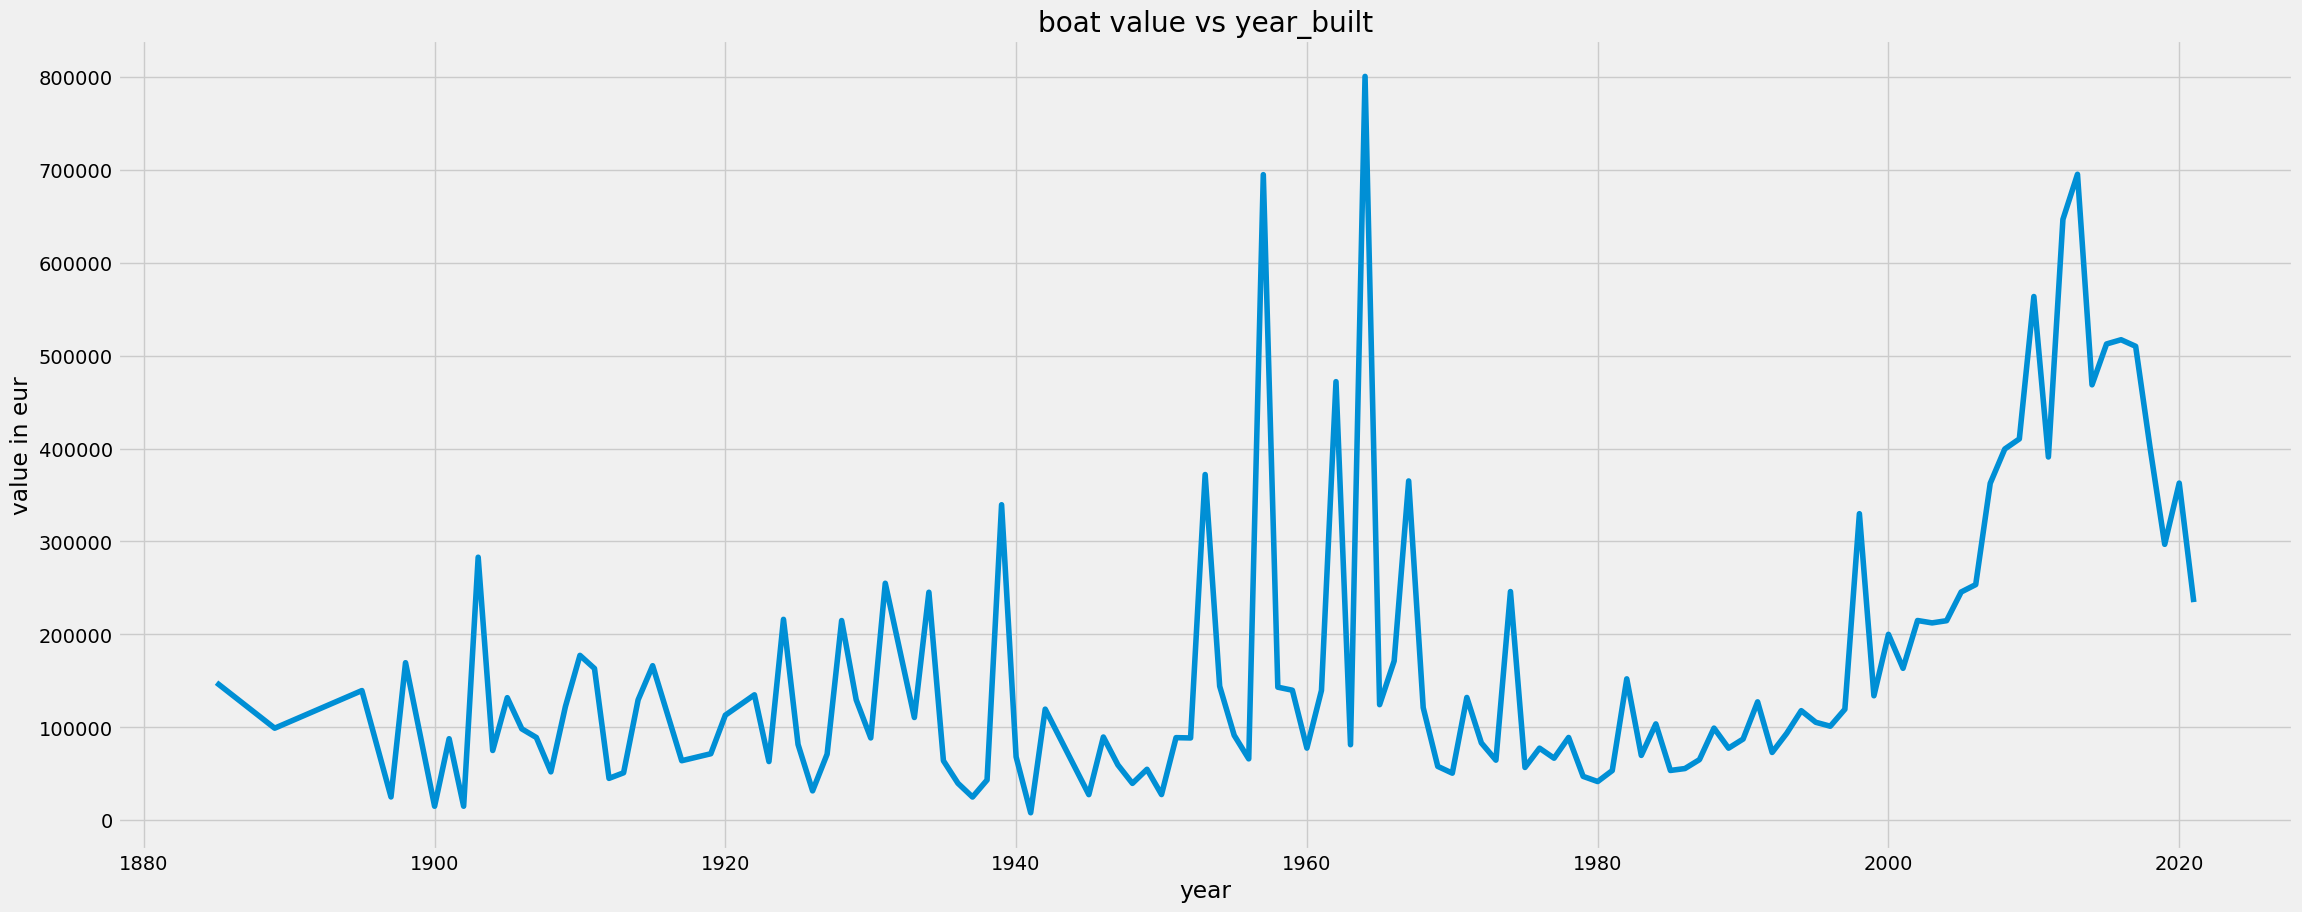

In [22]:
# creating a subset with only the year and mean value_in_eur column for further analysis
df_grouped = df.groupby('year_built').agg({'value_in_eur':['mean']})

plt.figure(figsize=(25,10), dpi=100) 
plt.title('boat value vs year_built')
plt.xlabel('year')
plt.ylabel('value in eur')
plt.plot(df_grouped)

In [7]:
# check for missing values
df_grouped.isnull().sum() 

value_in_eur  mean    0
dtype: int64

In [8]:
# Check for duplicates

dups = df_grouped.duplicated()
dups.sum()

# No dups!

3

# Decomposing the data 

In [11]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_grouped, model='additive')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

# due to above error we must define period for seasonality. In the graph above we see that there seems to be ups and downs every 4 or 5 years. Lets take four as a seasonality period

In [23]:
# decomposition = sm.tsa.seasonal_decompose(df_grouped, model='additive', period = 4)

In [24]:
# defining the fixed size of the plot

from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

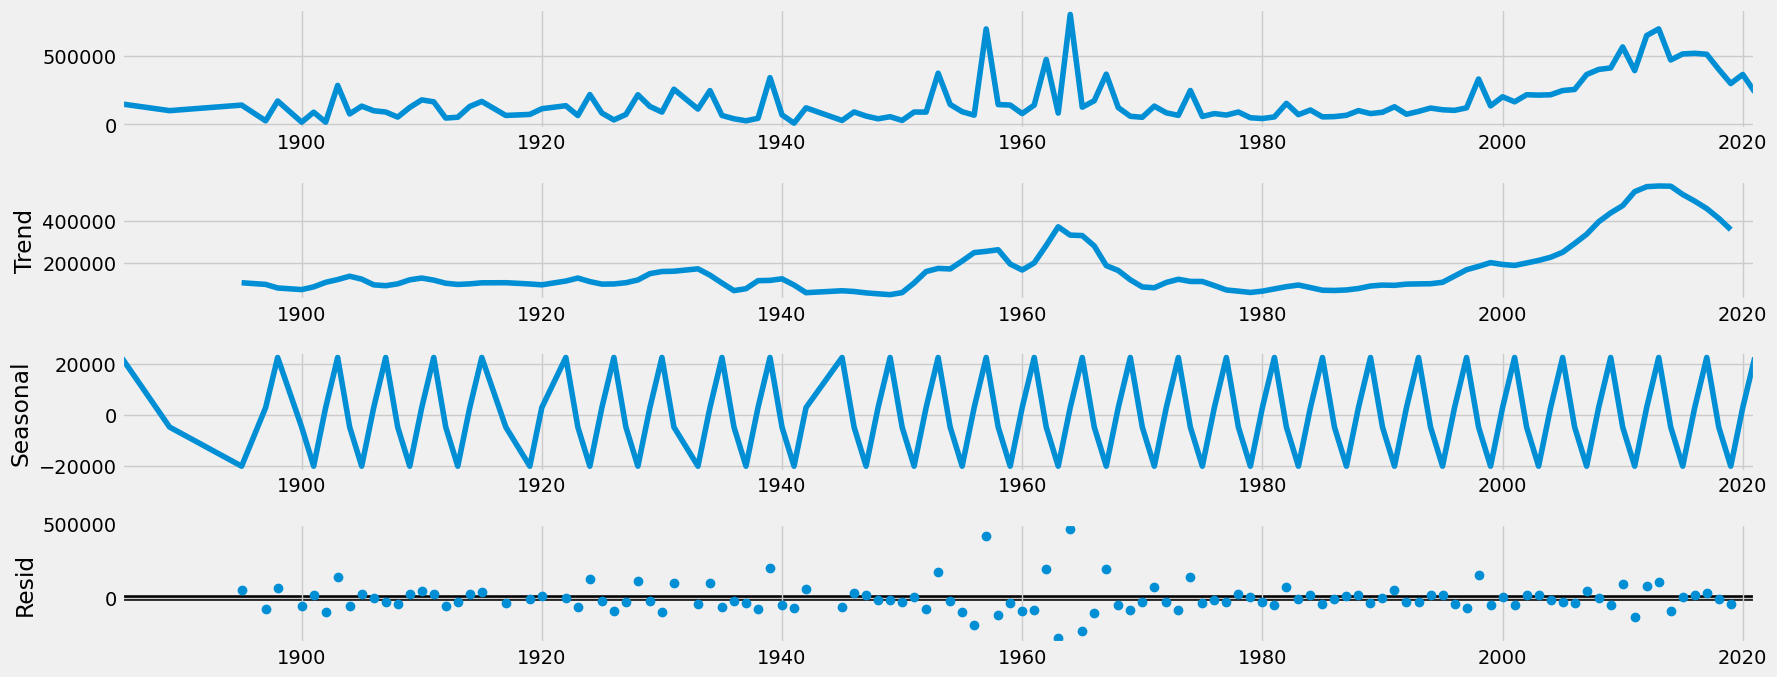

In [25]:
# showing the plot 
decomposition.plot()
plt.show()

# decomposition shows us a general price raise the newer the boat is. There are couple of price increases in the mean during 60s however generaly the boat keeps the trend of low price before 2000s.  This explains the "noise". That can be due to good condition of the boats which were built in 60s and its uniqueness or characteristics. 

# Stationarity test

In [26]:
# The adfuller() function imports from the model from statsmodels; but running it will only return an array of numbers
# This is the reason to define a function that prints the correct output from that array

# Importing the adfuller() function

from statsmodels.tsa.stattools import adfuller 

# Performing the Dickey-Fuller test:

def dickey_fuller(timeseries): # Define the function
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_grouped['value_in_eur'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.966731
p-value                          0.301348
Number of Lags Used              7.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


# p-value is  0.301348 and is higher as the 0.05. , Test Statistic is -1.966731 and Critical Value (5%) -2.887477 which means that  Test Statistic is larger than the critical value and the null hypothesis can not be rejected. 

# Autocorrelation

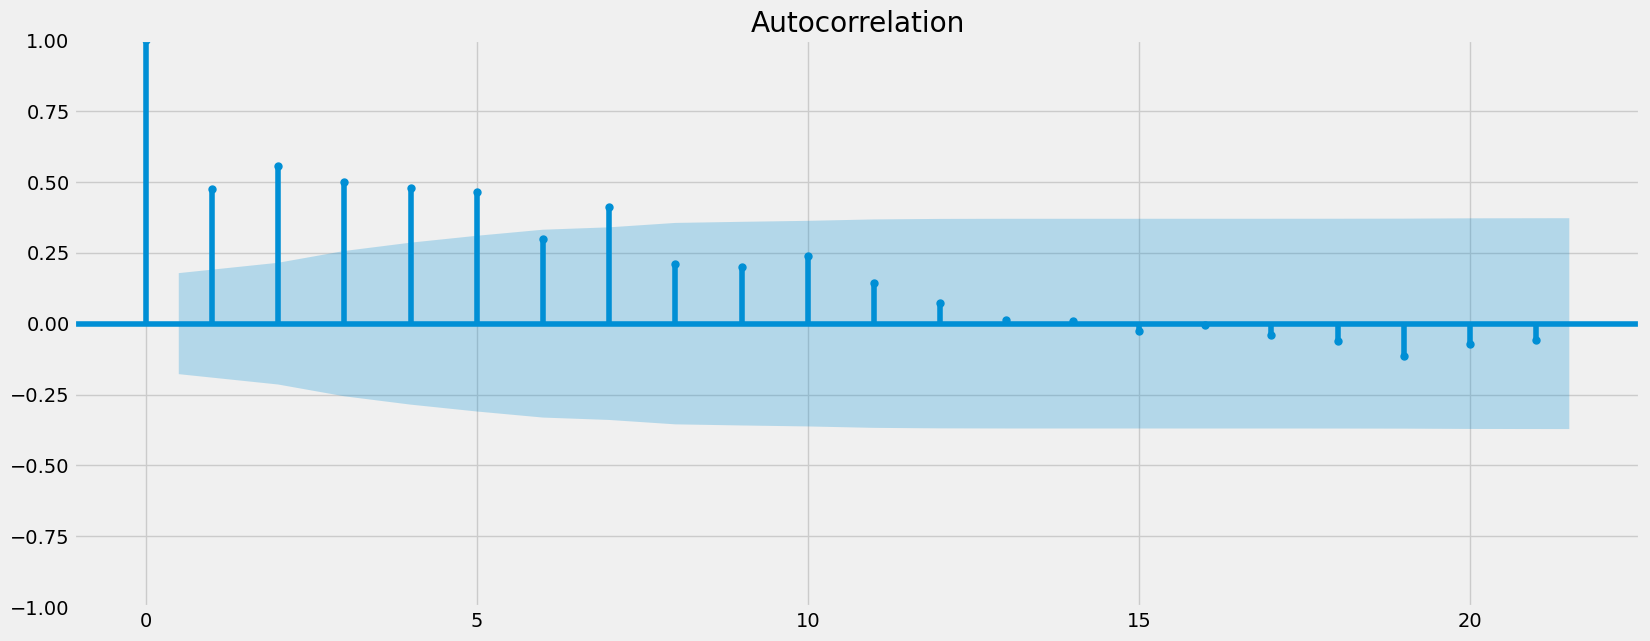

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_grouped)
plt.show()

# we see that the data is non stationary as a lot of lines of the chart in the autocorrelation are going above the confidence level, therefore we need to statinarize the data

# Stationarizing boats sells Data

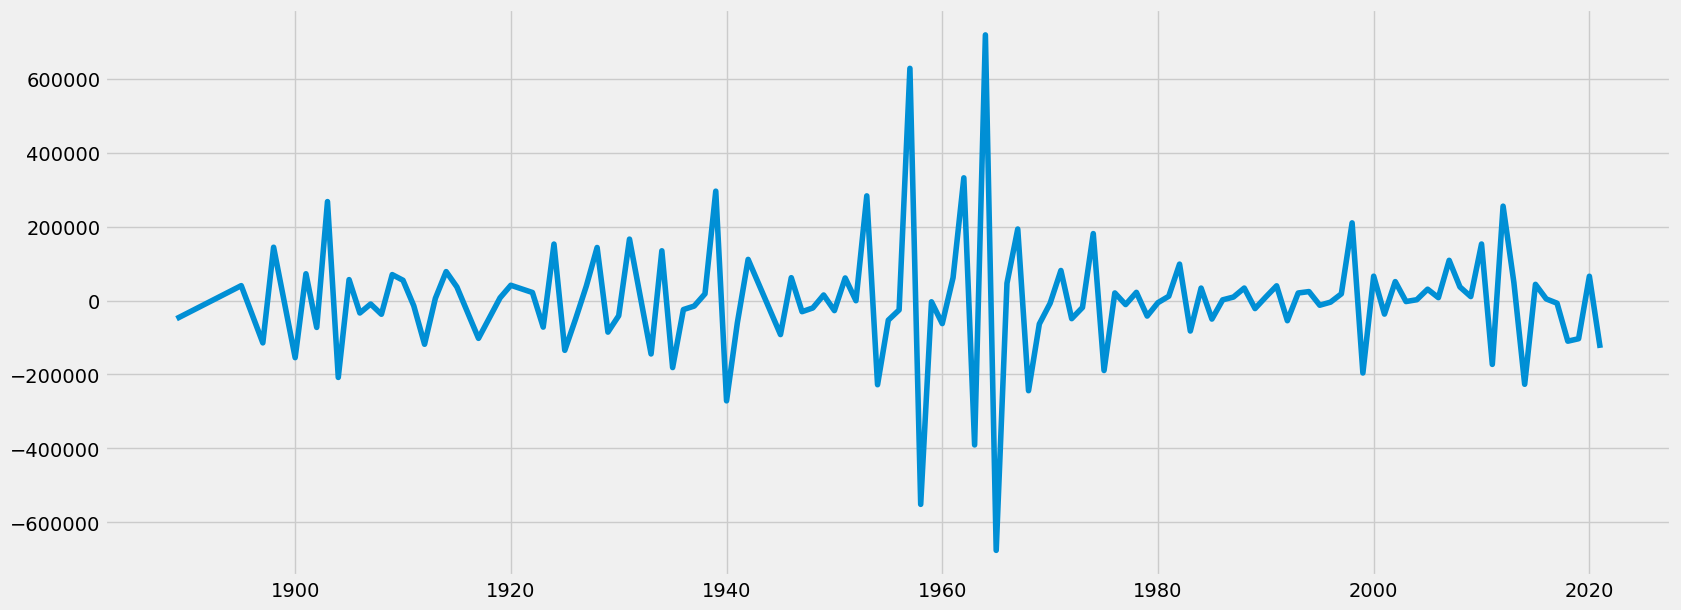

In [29]:
data_diff = df_grouped - df_grouped.shift(1)
data_diff.dropna(inplace = True)
plt.figure(figsize=(18,7), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -5.905953e+00
p-value                        2.708441e-07
Number of Lags Used            5.000000e+00
Number of Observations Used    1.140000e+02
Critical Value (1%)           -3.489058e+00
Critical Value (5%)           -2.887246e+00
Critical Value (10%)          -2.580481e+00
dtype: float64


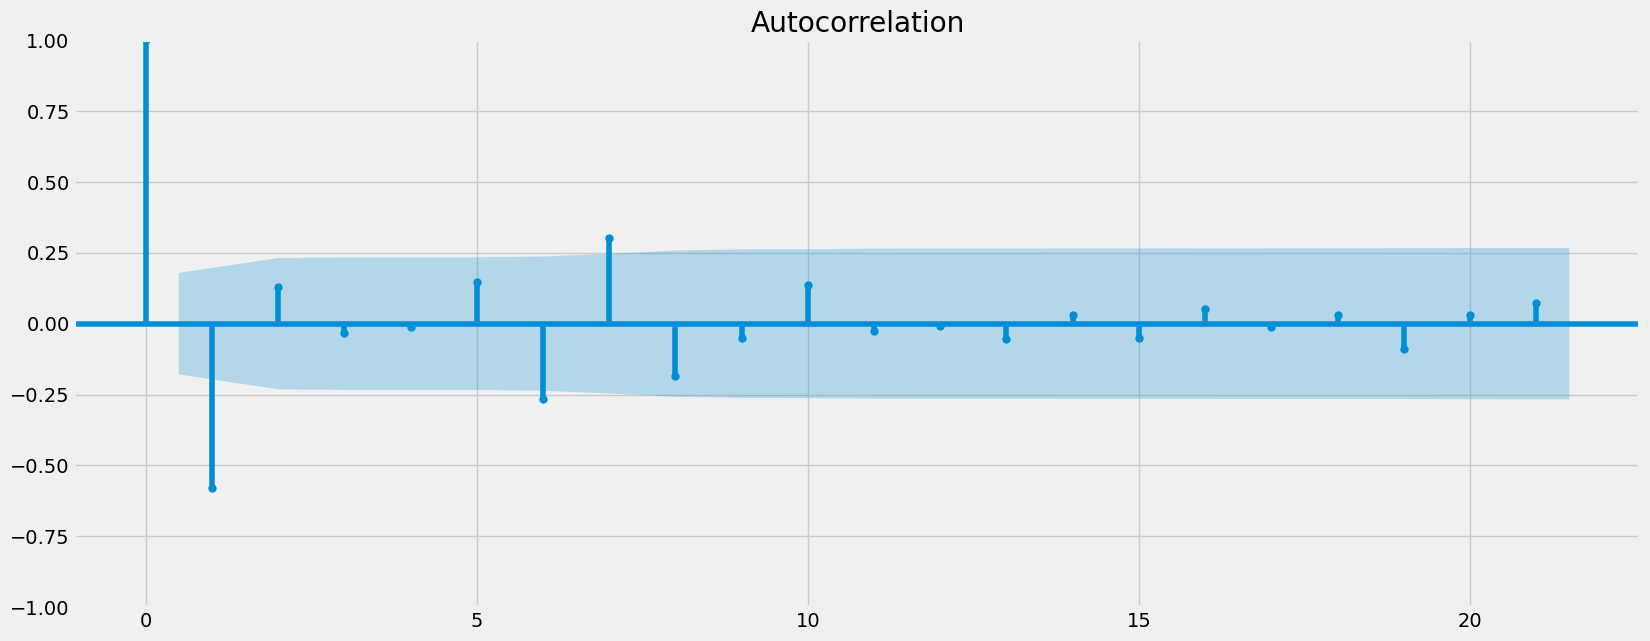

In [31]:
plot_acf(data_diff)
plt.show()

# we still see that the  p value is lower than 0.05. and the Test statistic is smaller  than critical value. we still see that some of the lines comes above  and below the confidence level, therefore need to perform another round of differencing 


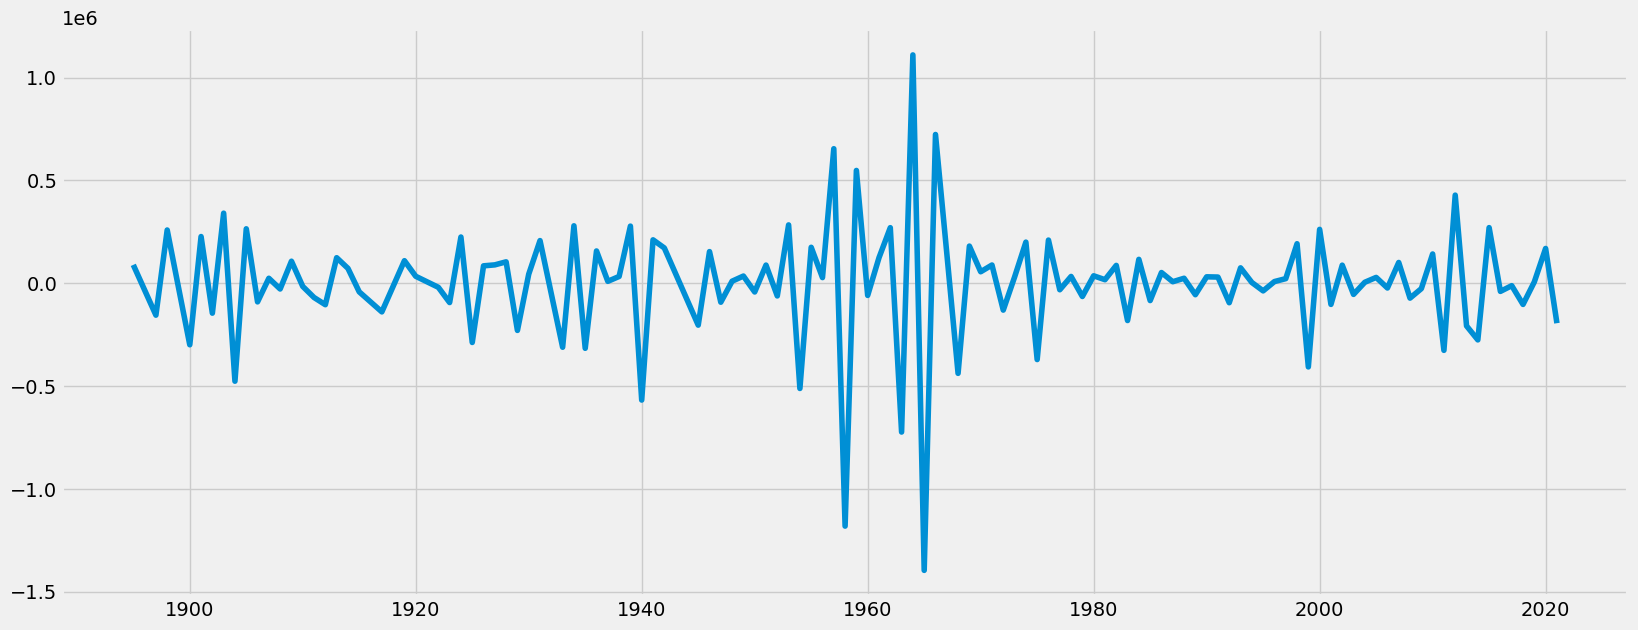

In [32]:
data_diff1 = data_diff - data_diff.shift(1)
data_diff1.dropna(inplace = True)
plt.figure(figsize=(18,7), dpi=100)
plt.plot(data_diff1)

In [33]:
dickey_fuller(data_diff1)

Dickey-Fuller Stationarity test:
Test Statistic                -6.561665e+00
p-value                        8.351612e-09
Number of Lags Used            9.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


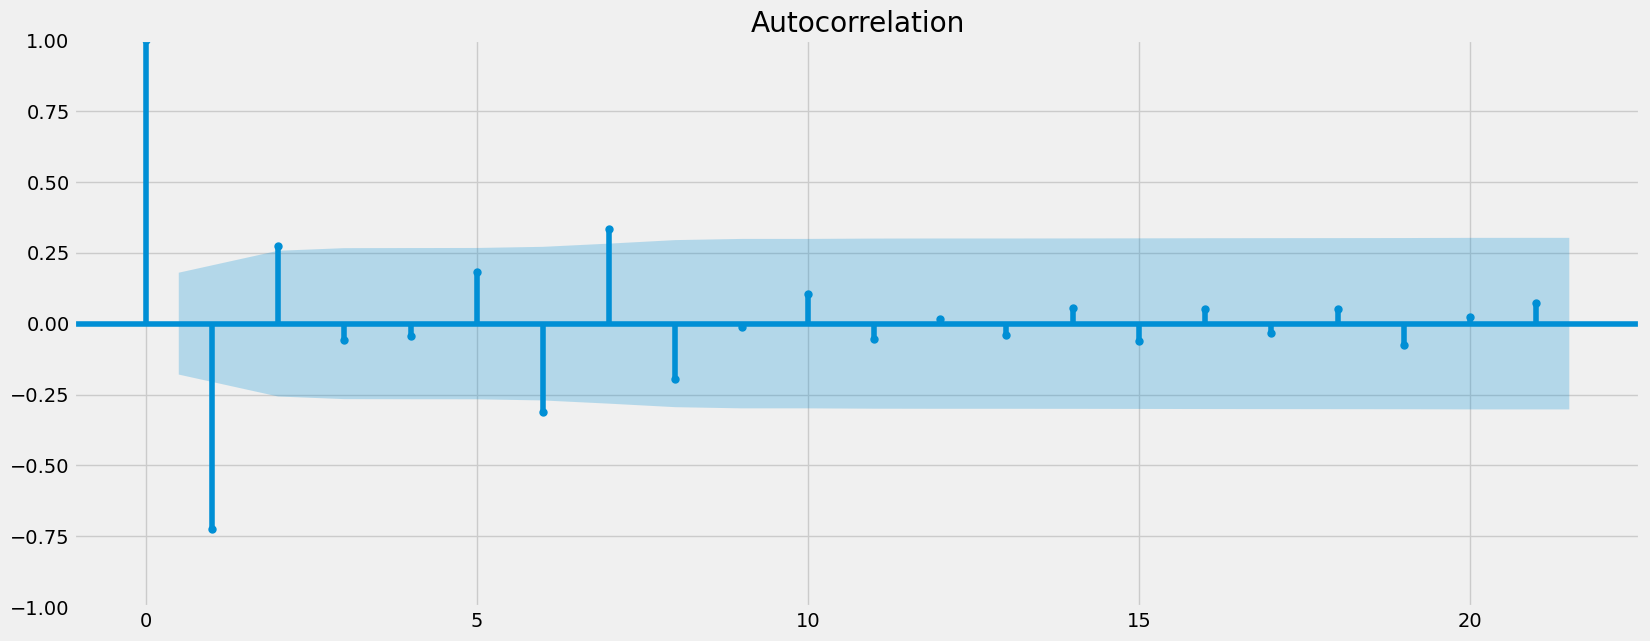

In [34]:
plot_acf(data_diff1)
plt.show()

# The autocorrelation still didnt show us the staionarity of the data due to one outlier at the beginning of the graph.  We see that the p value is less than 0.05. and test statistic is smaller than critical value. Data isnt staionar because some of the lines are comming below and above the confidence level